In [1]:
import numpy as np
import itertools
import random
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from jenga.cleaning.ppp import PipelineWithPPP
from jenga.cleaning.autoclean import AutoClean
from jenga.cleaning.outlier_removal import SKLearnIsolationForest
from jenga.cleaning.imputation import SimpleImputation

from jenga.corruptions.categorical import SwapValues
from jenga.corruptions.numeric import SwappedValues, Outliers, Scaling
from jenga.corruptions.text import BrokenCharacters
from jenga.corruptions.missing import ( MissingValuesHighEntropy, 
                                  MissingValuesLowEntropy, 
                                  MissingValues
                                )

%load_ext autoreload
%autoreload 2


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Titanic Example

In [2]:

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features),
        ('categorical_features', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.790


In [3]:
perturbation = Scaling(0.2, ['age','fare'])
# perturbation = SwappedValues(0.4, ['age','fare'])
# perturbation = MissingValues(0.7, 'fare',0,'MAR')
X_corrupted = perturbation(X_test.copy())

ac = AutoClean(X_train, 
               y_train, 
               clf,
               numeric_columns=numeric_features,
               categorical_columns=categorical_features
              )

X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': predicted_score_no_cleaning,
        'ppp_score_cleaned': np.array(cleaner_results_ppp).max()
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_013445/
2020-03-28 02:34:45,915 [Level 25]  No output_directory specified. Models will be saved in: AutogluonModels/ag-20200328_013445/
Beginning AutoGluon training ...
2020-03-28 02:34:45,916 [INFO]  Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200328_013445/
2020-03-28 02:34:45,918 [INFO]  AutoGluon will save models to AutogluonModels/ag-20200328_013445/
Train Data Rows:    1047
2020-03-28 02:34:45,919 [INFO]  Train Data Rows:    1047
Train Data Columns: 13
2020-03-28 02:34:45,920 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 02:34:45,921 [INFO]  Preprocessing data ...
2020-03-28 02:34:45,929 [Level 25]  Warning: Some classes in the training set have fewer than 10 examples. AutoGluon will only keep 3 out of 4 classes for training and will not try to predict the rare classes. To keep more classes, increase the number of datapoints from these rar

2020-03-28 02:35:17,131 [INFO]  Train Data Columns: 13
Preprocessing data ...
2020-03-28 02:35:17,132 [INFO]  Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
2020-03-28 02:35:17,145 [INFO]  Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Feature Generator processed 1047 data points with 54 features
2020-03-28 02:35:17,782 [INFO]  Feature Generator processed 1047 data points with 54 features
Original Features:
2020-03-28 02:35:17,784 [INFO]  Original Features:
	float features: 6
2020-03-28 02:35:17,785 [INFO]  	float features: 6
	object features: 6
2020-03-28 02:35:17,786 [INFO]  	object features: 6
Generated Features:
2020-03-28 02:35:17,788 [INFO]  Generated Features:
	int features: 42
2020-03-28 02:35:17,789 [INFO]  	int features: 42
All Features:
2020-03-28 02:35:17,791 [INFO]  All Features:
	float features: 6
2020-03-28 02:35:17,792 [INFO]  	float features: 6
	object features: 6
2020-03-28 02:35:17,795 [INFO]  	object features: 6
	in

AutoGluon will early stop models using evaluation metric: accuracy
2020-03-28 02:35:53,222 [Level 25]  AutoGluon will early stop models using evaluation metric: accuracy
Fitting model: RandomForestClassifierGini ...
2020-03-28 02:35:53,241 [INFO]  Fitting model: RandomForestClassifierGini ...
	0.9714	 = Validation accuracy score
2020-03-28 02:35:54,075 [INFO]  	0.9714	 = Validation accuracy score
	0.67s	 = Training runtime
2020-03-28 02:35:54,077 [INFO]  	0.67s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:35:54,078 [INFO]  	0.13s	 = Validation runtime
Fitting model: RandomForestClassifierEntr ...
2020-03-28 02:35:54,082 [INFO]  Fitting model: RandomForestClassifierEntr ...
	0.9619	 = Validation accuracy score
2020-03-28 02:35:54,908 [INFO]  	0.9619	 = Validation accuracy score
	0.67s	 = Training runtime
2020-03-28 02:35:54,910 [INFO]  	0.67s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:35:54,911 [INFO]  	0.13s	 = Validation runtime
Fitting model: Ext

2020-03-28 02:36:20,370 [INFO]  	-12.8175	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 02:36:20,371 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:36:20,373 [INFO]  	0.13s	 = Validation runtime
Fitting model: KNeighborsRegressorDist ...
2020-03-28 02:36:20,376 [INFO]  Fitting model: KNeighborsRegressorDist ...
	-12.858	 = Validation root_mean_squared_error score
2020-03-28 02:36:20,535 [INFO]  	-12.858	 = Validation root_mean_squared_error score
	0.03s	 = Training runtime
2020-03-28 02:36:20,538 [INFO]  	0.03s	 = Training runtime
	0.13s	 = Validation runtime
2020-03-28 02:36:20,540 [INFO]  	0.13s	 = Validation runtime
Fitting model: LightGBMRegressor ...
2020-03-28 02:36:20,543 [INFO]  Fitting model: LightGBMRegressor ...
	-10.5012	 = Validation root_mean_squared_error score
2020-03-28 02:36:20,930 [INFO]  	-10.5012	 = Validation root_mean_squared_error score
	0.36s	 = Training runtime
2020-03-28 02:36:20,932 [INFO]  	

	11.69s	 = Training runtime
2020-03-28 02:36:51,846 [INFO]  	11.69s	 = Training runtime
	0.22s	 = Validation runtime
2020-03-28 02:36:51,847 [INFO]  	0.22s	 = Validation runtime
Fitting model: LightGBMRegressorCustom ...
2020-03-28 02:36:51,851 [INFO]  Fitting model: LightGBMRegressorCustom ...
	-42.5708	 = Validation root_mean_squared_error score
2020-03-28 02:36:53,426 [INFO]  	-42.5708	 = Validation root_mean_squared_error score
	1.51s	 = Training runtime
2020-03-28 02:36:53,427 [INFO]  	1.51s	 = Training runtime
	0.02s	 = Validation runtime
2020-03-28 02:36:53,429 [INFO]  	0.02s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ...
2020-03-28 02:36:54,461 [INFO]  Fitting model: weighted_ensemble_k0_l1 ...
	-35.3749	 = Validation root_mean_squared_error score
2020-03-28 02:36:54,995 [INFO]  	-35.3749	 = Validation root_mean_squared_error score
	0.52s	 = Training runtime
2020-03-28 02:36:54,996 [INFO]  	0.52s	 = Training runtime
	0.0s	 = Validation runtime
2020-03-28 02:36

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/autogluon/utils/tabular/ml/learner/abstract_learner.py:357: UserWarning: There are 57 (out of 205) evaluation datapoints for which the label is missing. AutoGluon removed these points from the evaluation, which thus may not be entirely representative. You should carefully study why there are missing labels i

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [6]:
# debug
X_train

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1118,3.0,"Peltomaki, Mr. Nikolai Johannes",male,25.0000,0.0,0.0,STON/O 2. 3101291,7.9250,None,S,None,NaN,None
44,1.0,"Burns, Miss. Elizabeth Margaret",female,41.0000,0.0,0.0,16966,134.5000,E40,C,3,NaN,None
1072,3.0,"O'Connell, Mr. Patrick D",male,NaN,0.0,0.0,334912,7.7333,None,Q,None,NaN,None
1130,3.0,"Pettersson, Miss. Ellen Natalia",female,18.0000,0.0,0.0,347087,7.7750,None,S,None,NaN,None
574,2.0,"Turpin, Mr. William John Robert",male,29.0000,1.0,0.0,11668,21.0000,None,S,None,NaN,"Plymouth, England"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3.0,"Dean, Miss. Elizabeth Gladys 'Millvina'",female,0.1667,1.0,2.0,C.A. 2315,20.5750,None,S,10,NaN,"Devon, England Wichita, KS"
835,3.0,"Guest, Mr. Robert",male,NaN,0.0,0.0,376563,8.0500,None,S,None,NaN,None
1216,3.0,"Smyth, Miss. Julia",female,NaN,0.0,0.0,335432,7.7333,None,Q,13,NaN,None
559,2.0,"Sincock, Miss. Maude",female,20.0000,0.0,0.0,C.A. 33112,36.7500,None,S,11,NaN,"Cornwall / Hancock, MI"


In [4]:
cleaner_results_ppp, cleaner_results_true

([0.7161413562559693,
  0.7505253104106973,
  0.7161413562559693,
  0.7074180197389367],
 [0.7175572519083969,
  0.7175572519083969,
  0.7175572519083969,
  0.7061068702290076])

# Toy Data Example

(-1.8774763389668039, 4.73916889797604, -1.7047546030348233, 6.633577833428513)

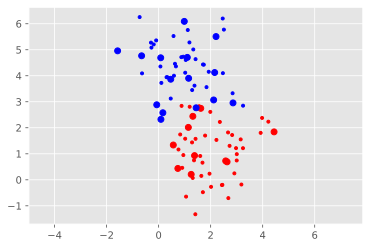

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_test.loc[y_test>0,0],X_test.loc[y_test>0,1],'ro',
         X_test.loc[y_test<=0,0],X_test.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

(-1.8774763389668039, 4.73916889797604, -2.6982524435588995, 7.594105043476921)

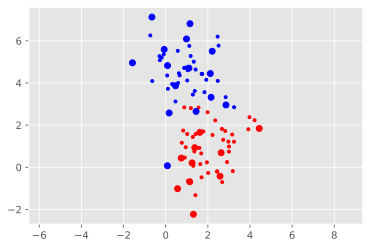

In [6]:
perturbation = Outliers(0.5, [1])
X_corrupted = perturbation(X_test.copy())

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_corrupted.loc[y_test>0,0],X_corrupted.loc[y_test>0,1],'ro',
         X_corrupted.loc[y_test<=0,0],X_corrupted.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

In [7]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = [0,1]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
clf = clf.fit(X_train, y_train)
print(f'Clean Test Score {clf.score(X_test, y_test)}')
print(f'Corrupted Test Score {clf.score(X_corrupted, y_test)}')

Clean Test Score 0.88
Corrupted Test Score 0.88


In [8]:
from jenga.cleaning.ppp import PipelineWithPPP
ppp = PipelineWithPPP(clf, 
                      numeric_columns=numeric_features, 
                      categorical_columns=[],
                      num_repetitions=5,
                      perturbation_fractions=[.1,.3, .5, .6, .75, .9, .99]
                     )

ppp.fit_ppp(X_train, y_train)
print(f'Predicted clean score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')
print(f'Predicted corrupted score: {ppp.predict_ppp(X_corrupted):.4f}, true score {clf.score(X_corrupted, y_test):.4f}')


Predicted clean score: 0.8782, true score 0.8800
Predicted corrupted score: 0.9138, true score 0.8800


In [9]:
ac = AutoClean(X_train, 
               y_train, 
               clf, 
               numeric_columns=[0,1], 
               categorical_columns=[]
              )
X_cleaned, predicted_score, cleaner_results_ppp, cleaner_results_true  = ac(X_corrupted.copy(deep=True), y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
        'ppp_score_cleaned': ppp.predict_ppp(X_cleaned)
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

perturbation:Outliers: {'fraction': 0.5, 'columns': [1]}
clean_data_test_score:0.88
corrupted_data_test_score:0.88
cleaned_data_test_score:0.88
ppp_score_corrupted:0.9137777777777778
ppp_score_cleaned:0.9137777777777778


In [10]:
cleaner_results_ppp, cleaner_results_true

([0.8711111111111112,
  0.8497777777777779,
  0.8711111111111112,
  0.8497777777777779],
 [0.88, 0.8, 0.88, 0.8])

# OpenML Example

In [11]:
corruptions = {
    'numeric':[Outliers, Scaling],
    'categorical':[SwapValues],
    'missing': [MissingValuesHighEntropy, 
                MissingValuesLowEntropy, 
                MissingValues]
}

def get_random_perturbation(numerical_columns, 
                            categorical_columns, 
                            fractions=[.2, .5, .7, .9]):
    '''
    Returns a random perturbation, chosen from either a numeric (swapping, outlier, scaling)
    or missingness
    '''
    
    if len(numerical_columns)>0 and len(categorical_columns)>0:
        perturbation_type = random.choice(list(corruptions.keys()))
    elif len(numerical_columns)>0:
        perturbation_type = 'numeric'
    elif len(categorical_columns)>0:
        perturbation_type = 'categorical'
    else:
        print("need at least one categorical or numeric column")
        
    random_fraction = random.choice(fractions)
    if perturbation_type is 'missing':
        missingness = random.choice(['MCAR', 'MAR', 'MNAR'])
        rand_column = random.choice(categorical_columns + numerical_columns)
        if rand_column in numerical_columns:
            missing_value = 0
        else:
            missing_value = ''
        return MissingValues(random_fraction, rand_column, missing_value, missingness)
    elif perturbation_type is 'numeric':
        perturbation = random.choice(corruptions[perturbation_type])
        rand_column = random.choice(numerical_columns)
        return perturbation(random_fraction, [rand_column])
    elif perturbation_type is 'categorical':
        rand_column = random.choice(categorical_columns)
        return SwapValues(random_fraction, rand_column)

# https://www.openml.org/search?q=qualities.NumberOfClasses%3A2%2520qualities.NumberOfInstances%3A100..10000%2520qualities.NumberOfFeatures%3A10..100&type=data
experiments = [
    'ionosphere',
    'sonar',
    'heart-statlog',
    'parkinsons',
    'KnuggetChase3',
    'Satellite',
    'fertility',
    'steel-plates-fault',
    'profb',
    'sick',
    'credit-g',
    'churn',
#     'bank-marketing',
    'cleve',
    'mushroom',
    'colic',
    'soybean'
 ]


In [12]:
def run_experiment(exp_id, n_perturbations=3):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    n_perturb = np.random.randint(1,n_perturbations)
    print(f'Applying {n_perturb} perturbations')
    X_corrupted = X_test.copy()
    for _ in range(n_perturb):
        perturbation = get_random_perturbation(numeric_features, categorical_features)
        print(perturbation)
        X_corrupted = perturbation(X_corrupted)

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numeric_columns=numeric_features, 
                   categorical_columns=categorical_features
                  )
    
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': predicted_score_no_cleaning,
            'ppp_score_cleaned': np.array(cleaner_results_ppp).max(),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result

In [13]:
results = []
for _ in range(20):
    results.append(run_experiment(random.choice(experiments)))

********************************************************************************
Fetching dataset soybean
Found 35 categorical and 0 numeric features
model score: 0.956
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'germination'}
SwapValues: {'fraction': 0.2, 'column': 'crop-hist'}


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


perturbation:SwapValues: {'fraction': 0.2, 'column': 'crop-hist'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9635036496350365
cleaned_data_test_score:0.9635036496350365
ppp_score_corrupted:0.968009768009768
ppp_score_cleaned:0.968009768009768
cleaner_results_ppp:[0.968009768009768, 0.9675213675213675, 0.9658119658119658, 0.9617826617826618]
cleaner_results_true:[0.9635036496350365, 0.8905109489051095, 0.8029197080291971, 0.7883211678832117]
********************************************************************************
Fetching dataset churn
Found 4 categorical and 16 numeric features
model score: 0.867
Applying 1 perturbations
SwapValues: {'fraction': 0.7, 'column': 'number_customer_service_calls'}


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


perturbation:SwapValues: {'fraction': 0.7, 'column': 'number_customer_service_calls'}
clean_data_test_score:0.867
corrupted_data_test_score:0.846
cleaned_data_test_score:0.846
ppp_score_corrupted:0.8354833333333335
ppp_score_cleaned:0.8552666666666666
cleaner_results_ppp:[0.8354833333333335, 0.8552666666666666, 0.8354833333333335, 0.8530333333333332]
cleaner_results_true:[0.846, 0.846, 0.846, 0.846]
********************************************************************************
Fetching dataset fertility
Found 0 categorical and 9 numeric features
model score: 0.950
Applying 1 perturbations
Scaling: {'fraction': 0.9, 'columns': ['V4']}
perturbation:Scaling: {'fraction': 0.9, 'columns': ['V4']}
clean_data_test_score:0.95
corrupted_data_test_score:0.95
cleaned_data_test_score:0.95
ppp_score_corrupted:0.8616666666666668
ppp_score_cleaned:0.8616666666666668
cleaner_results_ppp:[0.8616666666666668, 0.8616666666666668, 0.8616666666666668, 0.8616666666666668]
cleaner_results_true:[0.95, 0.95,

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


model score: 0.949
Applying 2 perturbations
SwapValues: {'fraction': 0.2, 'column': 'seed'}
SwapValues: {'fraction': 0.9, 'column': 'plant-stand'}
perturbation:SwapValues: {'fraction': 0.9, 'column': 'plant-stand'}
clean_data_test_score:0.948905109489051
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9606837606837607
ppp_score_cleaned:0.9606837606837607
cleaner_results_ppp:[0.9606837606837607, 0.95995115995116, 0.9533577533577534, 0.9537240537240538]
cleaner_results_true:[0.9562043795620438, 0.8905109489051095, 0.7883211678832117, 0.781021897810219]
********************************************************************************
Fetching dataset Satellite
Found 0 categorical and 36 numeric features
model score: 0.991
Applying 2 perturbations
Scaling: {'fraction': 0.9, 'columns': ['V12']}
Outliers: {'fraction': 0.5, 'columns': ['V35']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['V35']}
clean_data_test_score:0.99117

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


perturbation:MissingValues: {'column': 'phone_number', 'fraction': 0.5, 'na_value': 0, 'missingness': 'MNAR'}
clean_data_test_score:0.869
corrupted_data_test_score:0.867
cleaned_data_test_score:0.867
ppp_score_corrupted:0.8555333333333331
ppp_score_cleaned:0.8555333333333331
cleaner_results_ppp:[0.8555333333333331, 0.8530833333333331, 0.8555333333333331, 0.8518666666666665]
cleaner_results_true:[0.867, 0.865, 0.867, 0.865]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.836
Applying 2 perturbations
Scaling: {'fraction': 0.5, 'columns': ['Max_heart_rate']}
Outliers: {'fraction': 0.2, 'columns': ['Oldpeak']}
perturbation:Outliers: {'fraction': 0.2, 'columns': ['Oldpeak']}
clean_data_test_score:0.8360655737704918
corrupted_data_test_score:0.5901639344262295
cleaned_data_test_score:0.5573770491803278
ppp_score_corrupted:0.7305785123966941
ppp_score_cleaned:0.7418732782369145
cl

In [14]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')

In [15]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')
cleaner_ppp = list(itertools.chain(*df_results['cleaner_results_ppp']))
cleaner_true = list(itertools.chain(*df_results['cleaner_results_true']))

In [40]:
def run_experiment_nonlinear(exp_id, n_perturbations=3):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])

    
    param_grid = {
            'n_estimators': np.arange(5, 100, 10)
        }

    classifier = GridSearchCV(RandomForestClassifier(), param_grid)
        
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    n_perturb = np.random.randint(1,n_perturbations)
    print(f'Applying {n_perturb} perturbations')
    X_corrupted = X_test.copy()
    for _ in range(n_perturb):
        perturbation = get_random_perturbation(numeric_features, categorical_features)
        print(perturbation)
        X_corrupted = perturbation(X_corrupted)

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numeric_columns=numeric_features, 
                   categorical_columns=categorical_features
                  )
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': predicted_score_no_cleaning,
            'ppp_score_cleaned': np.array(cleaner_results_ppp).max(),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result
    

In [57]:
df_results_nonlinear = pd.read_csv('results_nonlinear.csv')
df_results_nonlinear['cleaner_results_ppp'] = df_results_nonlinear['cleaner_results_ppp'].apply(lambda x: [float(y.strip()) for y in x[2:-3].split(',')])
df_results_nonlinear['cleaner_results_true'] = df_results_nonlinear['cleaner_results_true'].apply(lambda x: [float(y.strip()) for y in x[2:-3].split(',')])

In [ ]:
results_nonlinear = []
for _ in range(30):
    results_nonlinear.append(run_experiment_nonlinear(random.choice(experiments)))

df_results_nonlinear = pd.DataFrame(results_nonlinear)
df_results_nonlinear.to_csv('results_nonlinear.csv')

# Preliminary Results

## How Well does work PPP for Autocleaning ?

Not very well it seems so far. 

Each dot is a data set with different perturbations and 4 different cleaning options, indicated by color. 

X-axis is PPP prediction, y-axis true performance. 

Dots falling above the line indicate PPP is overestimating the true effect of cleaning. 

When no cleaning is applied (red dots), PPP seems to perform well. 

But then againn, PPP hasn't seen data sets that were cleaned. We could try to alleviate that problem by showing it more cleaned data?

Text(0, 0.5, 'PPP Predicted Accuracy')

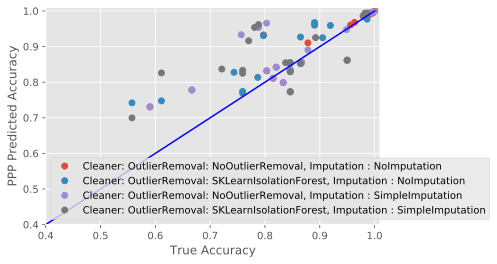

In [71]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cleaner_ppp = np.vstack(df_results['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results['cleaner_results_true'])
plt.plot(cleaner_true, cleaner_ppp, 'o')
plt.legend(ac.cleaners, loc='lower left')
plt.plot([0,1],[0,1],'b-')
plt.ylim([.4,1.01])
plt.xlim([.4,1.01])
plt.xlabel('True Accuracy')
plt.ylabel('PPP Predicted Accuracy')

## How Useful are the Data Cleaning Options Tested?

Not very useful it seems - the red dots falling on the iso-performance line indicate that the best cleaning accuracy (y-axis) is just as good as the accuarcy when not doing any cleaning (x-axis).

As a sanity check, the blue crosses show, in slight abuse of the same axis, that the corruptions applied to the data indeed to lead to worse performance. 

Text(0, 0.5, 'Cleaning')

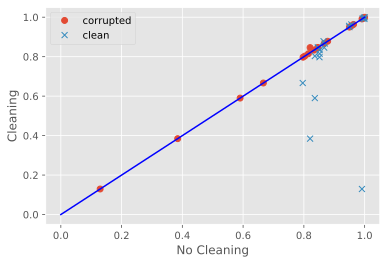

In [69]:
cleaner_ppp = np.vstack(df_results['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results['cleaner_results_true'])
plt.plot(df_results['corrupted_data_test_score'], cleaner_true.max(axis=1), 'o',
         df_results['clean_data_test_score'], cleaner_true.max(axis=1),'x')
plt.legend(['corrupted', 'clean'], loc='upper left')
plt.plot([0,1],[0,1],'b-')
plt.xlabel('No Cleaning')
plt.ylabel('Cleaning')

## For non-linear black-box models, it seems to be even worse ... 

It seems that PPP consistently overestimates the true predictive performance for nonlinear black box models. 

Text(0, 0.5, 'PPP Predicted Accuracy')

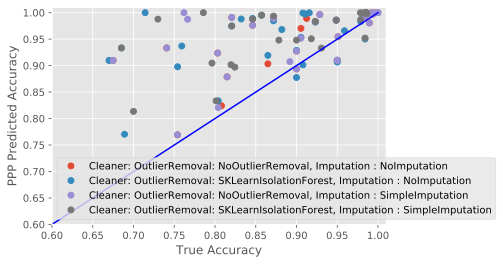

In [70]:
cleaner_ppp = np.vstack(df_results_nonlinear['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results_nonlinear['cleaner_results_true'])
plt.plot(cleaner_true, cleaner_ppp, 'o')
plt.legend(ac.cleaners, loc='lower left')
plt.plot([0,1],[0,1],'b-')
plt.ylim([.6,1.01])
plt.xlim([.6,1.01])
plt.xlabel('True Accuracy')
plt.ylabel('PPP Predicted Accuracy')

## Also for non-linear black-box models, cleaning doesn't seem to help

Same plot as for linear models above, in most cases cleaning corrupted data does not improve predictive performance 

(0.6, 1.01)

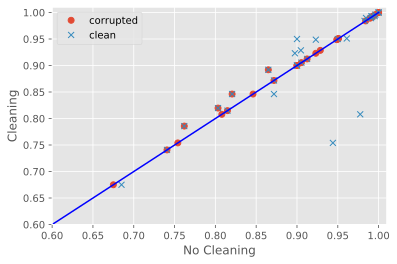

In [72]:
cleaner_ppp = np.vstack(df_results_nonlinear['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results_nonlinear['cleaner_results_true'])
plt.plot(df_results_nonlinear['corrupted_data_test_score'], cleaner_true.max(axis=1), 'o',
         df_results_nonlinear['clean_data_test_score'], cleaner_true.max(axis=1),'x')
plt.legend(['corrupted', 'clean'], loc='upper left')
plt.plot([0,1],[0,1],'b-')
plt.xlabel('No Cleaning')
plt.ylabel('Cleaning')
plt.ylim([.6,1.01])
plt.xlim([.6,1.01])

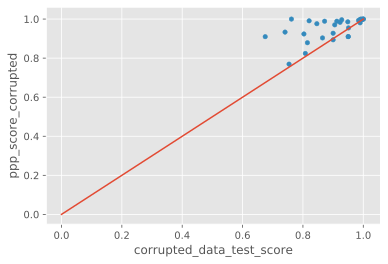

In [66]:
df_results_nonlinear.plot.scatter('corrupted_data_test_score','ppp_score_corrupted')
plt.plot([0,1],[0,1],'-')